In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from google.protobuf import text_format
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from art.attacks.evasion import PixelAttack
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt
import numpy as np
import pickle
from onePixelAttack import loadAttackData


# Resnet

In [3]:
EPOCHS = 1
BATCH_SIZE = 64
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                                              include_top=False,
                                                              weights='imagenet')(inputs)
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy']) 
  return model

In [26]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)
resnet = define_compile_model()
resnet = tf.keras.models.load_model('./trainedModel')


In [27]:
# Some statistics I used in a previous ML class
def analysis(model, X, Y, classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']):
    ypred = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(Y, ypred)
    cr = classification_report(Y, ypred)
    print('Test Statistics:', cr, sep='\n', end='\n\n\n')

    print('Confusion Matrix:')
    sns.heatmap(cm, linewidth=0.5, annot=cm, xticklabels=classes, yticklabels=classes)
    plt.show()

# Get image datasets

In [44]:
X_attacked, X_unattacked, y = loadAttackData('attacked.imgs')
X_attacked = np.asarray(X_attacked) / 255   # Scale RGB values between 0 and 1.0
X_unattacked = np.asarray(X_unattacked) / 255   # Scale RGB values between 0 and 1.0
X_attacked_test = X_attacked[0:int(len(X_attacked)/3)]
X_attacked_train = X_attacked[int(len(X_attacked)/3):]
X_unattacked_test = X_unattacked[0:int(len(X_unattacked)/3)]
X_unattacked_train = X_unattacked[int(len(X_unattacked)/3):]
y_test = np.asarray(y[0:int(len(y)/3)])
y_train = np.asarray(y[int(len(y)/3):])

# Analyze Resnet model with unattacked images

31/31 [==============================] - 48s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       103
           1       0.95      0.83      0.88        88
           2       0.82      0.78      0.80       103
           3       0.60      0.77      0.67        91
           4       0.89      0.75      0.81       102
           5       0.94      0.53      0.68        86
           6       0.90      0.82      0.86       104
           7       0.75      0.88      0.81        94
           8       0.94      0.80      0.86       110
           9       0.96      0.86      0.91       107

    accuracy                           0.80       988
   macro avg       0.83      0.80      0.80       988
weighted avg       0.84      0.80      0.81       988



Confusion Matrix:


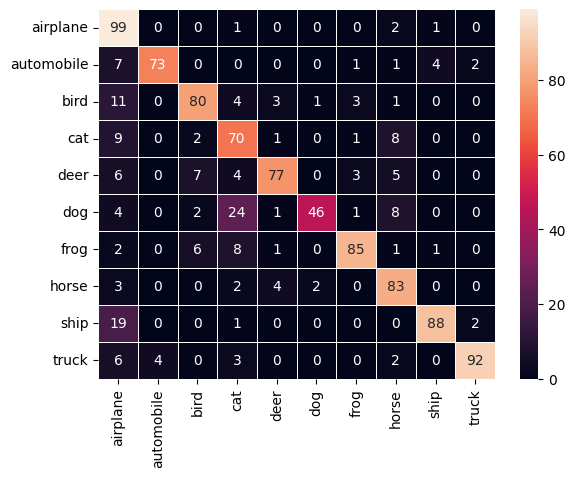

In [49]:
analysis(resnet, X_unattacked_train*255, y_train)

# Analyze Resnet with Attacked Images

16/16 [==============================] - 24s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.30      0.90      0.45        50
           1       0.81      0.73      0.77        63
           2       0.29      0.47      0.36        43
           3       0.33      0.46      0.39        46
           4       0.50      0.10      0.17        50
           5       0.56      0.38      0.45        40
           6       0.82      0.17      0.28        53
           7       0.74      0.51      0.60        49
           8       0.56      0.45      0.50        44
           9       0.82      0.56      0.67        55

    accuracy                           0.48       493
   macro avg       0.57      0.47      0.46       493
weighted avg       0.59      0.48      0.47       493



Confusion Matrix:


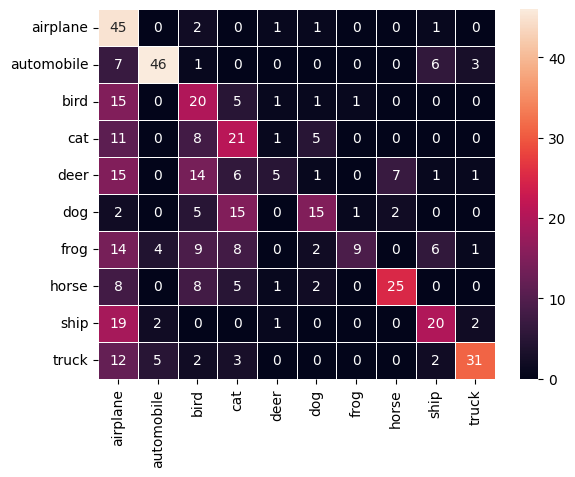

In [50]:
analysis(resnet, X_attacked_test*255, y_test)

16/16 [==============================] - 25s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.47      0.92      0.62        50
           1       0.98      0.78      0.87        63
           2       0.67      0.65      0.66        43
           3       0.45      0.70      0.55        46
           4       0.82      0.54      0.65        50
           5       0.78      0.45      0.57        40
           6       0.88      0.57      0.69        53
           7       0.73      0.88      0.80        49
           8       0.76      0.70      0.73        44
           9       0.93      0.71      0.80        55

    accuracy                           0.70       493
   macro avg       0.75      0.69      0.69       493
weighted avg       0.76      0.70      0.70       493



Confusion Matrix:


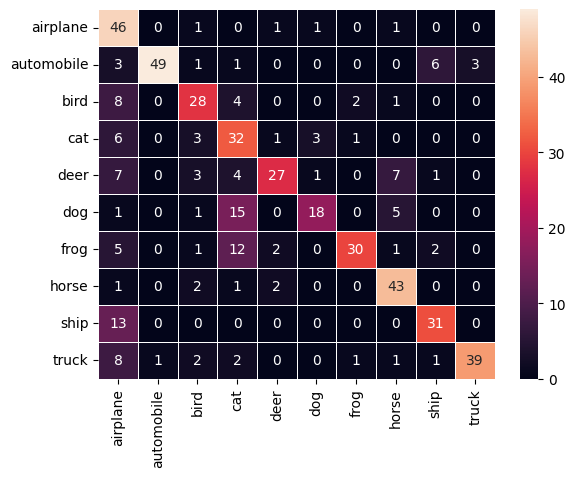

In [51]:
counter_adversarial = tf.keras.models.load_model('./trained_fully_conv')
tmp = counter_adversarial.predict(X_attacked_test)
analysis(resnet, tmp*255, y_test)